# Citibike Stations' Inflow/Outflow Ratio
Group Members:
Cindy Y. Liu, Yuxiang Zhang

In [1]:
#Load Default settings
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline
import json
# pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Citibike data
df = pd.read_csv('201508-citibike-tripdata.csv')

In [9]:
# df['date'] = pd.to_datetime(df['starttime'])

In [10]:
# Drop unnecessary features
df = df.drop(['tripduration','starttime','stoptime'],axis=1)

In [11]:
## Store the information of stations into a csv file. including longitude latitude, and id
start = pd.DataFrame({'id': df['start station id'], \
                    'lat': df['start station latitude'],\
                    'lon':df['start station longitude']})
end = pd.DataFrame({'id': df['end station id'], \
                    'lat': df['end station latitude'],\
                    'lon':df['end station longitude']})
merged = pd.concat([start,end],axis=0)
merged = merged.drop_duplicates('id')
merged.to_csv('station.csv')   

We use ArcGis to reverse Geocoding the latitude and longitude information into a real street information. We get the borough information for each Citibike station and store the information into the stationbyborough.csv

In [8]:
stations_by_borough = pd.read_csv('stationbyborough.csv')

In [12]:
in_jour, out_jour, in_out_ratio = np.zeros(len(stations_by_borough)),np.zeros(len(stations_by_borough)),np.zeros(len(stations_by_borough))

In [16]:
# Iterate through all the stations to get the total inflow and outflow information of each station
for index, station in stations_by_borough.iterrows():
    s = sum(df['start station id']==station['id'])
    e = sum(df['end station id']==station['id'])
    in_jour[index]= s
    out_jour[index]= e
    in_out_ratio[index]=s/float(e)

In [17]:
# Create a new data frame which includes all the inflow and outflow information of each station
results = pd.DataFrame({'sid':stations_by_borough['id'],\
                      'inflow':in_jour,\
                      'outflow':out_jour,\
                      'ratio':in_out_ratio,\
                      'borough':stations_by_borough['BoroName']})
cols = ['sid','inflow','outflow','ratio','borough']
results = results[cols]
results.to_csv('results.csv')

In [18]:
results.describe()

,sid,inflow,outflow,ratio
count,421.000000,421.000000,421.000000,421.000000
mean,1020.299287,2800.579572,2800.579572,0.997127
std,1143.676593,2478.491485,2437.574067,0.121560
min,72.000000,0.000000,1.000000,0.000000
25%,317.000000,674.000000,684.000000,0.970722
50%,434.000000,2486.000000,2419.000000,0.995874
75%,2001.000000,4276.000000,4296.000000,1.019231
max,3224.000000,14498.000000,11912.000000,1.897590


In [19]:
results.groupby('borough').count()

,sid,inflow,outflow,ratio
borough,,,,
Brooklyn,148,148,148,148
Manhattan,262,262,262,262
Queens,11,11,11,11


## Statistical Analysis

KeyError: 0

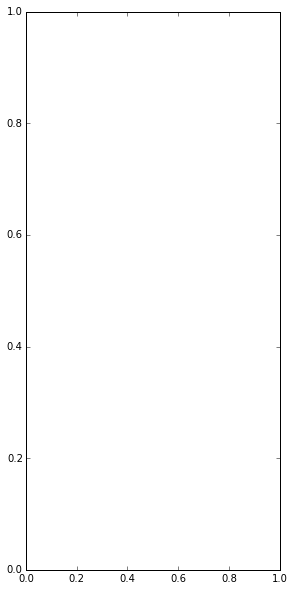

In [44]:
manhattan = results[results['borough']=='Manhattan']
brooklyn = results[results['borough']=='Brooklyn']

norm_m = 1
norm_b = 1

error_m = np.sqrt(manhattan['ratio'].count())
error_b = np.sqrt(brooklyn['ratio'].count())

fig = pl.figure(figsize(10,10))

pl.subplot(121)
pl.hist(manhattan['ratio'],yerr=[((error_m)/norm_m,(error_m)/norm_m)],bins=30,color='IndianRed', alpha=0.5,label='Manhattan Stations')

          

#pl.subplot(122)
#brooklyn['ratio'].plot(kind="hist",yerr=[((error_b)/norm_b,(error_b)/norm_b)],\
                       #bins=30, alpha=0.5,label='Brooklyn Stations')


# pl.legend(['Brooklyn Stations','Manhattan Stations'],fontsize=15)
# pl.title('Stations\' Inflow/Outflow Rate by Borough')

# Hypothesis: Manhattan has less inflow riders than Brooklyn.

# t test for the mean of the inflow/outflow ratio of two samples.

$H_{0} : mean_m-mean_b>0$

$H_{\alpha}: mean_m-mean_b<=0$

In [72]:
import scipy.stats as ss
mean_m = np.mean(manhattan['ratio'])
mean_b = np.mean(brooklyn['ratio'])
std_m = np.std(manhattan['ratio'])
std_b = np.std(brooklyn['ratio'])
n_m = len(manhattan)
n_b = len(brooklyn)

t, p = ss.ttest_ind(manhattan['ratio'],brooklyn['ratio'],equal_var = False)
print "ttest_ind: t = %g  p = %g" % (t, p)

ttest_ind: t = 0.150304  p = 0.880645


In [73]:
alpha = 0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)
   
    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

    
report_result(p,alpha)

Is the p value 0.88 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected


# Z test for the proportion of inflow to total flow (inflow+outflow) in two samples.

$H_{0} : p_m-p_b>0$

$H_{\alpha}: p_m-p_b<=0$

In [23]:
P_0 = sum(manhattan['inflow'])/float(sum(manhattan['inflow']) + \
                                     sum(manhattan['outflow']))
P_1 = sum(brooklyn['inflow'])/float(sum(brooklyn['inflow']) + \
                                     sum(brooklyn['outflow']))

n_0 = len(manhattan)
n_1 = len(brooklyn)

Nt_0 = P_0*n_0
Nt_1 = P_1*n_1
print (P_0, P_1, n_0, n_1)

# Pooled Sample Proportion
psp = (P_0*n_0+P_1*n_1)/(n_1+n_0)

SE = lambda p, n1, n2: np.sqrt(psp*(1-psp)*(1/float(n1)+1/float(n2)))

se = SE(P_0,n_0,n_1)

# Z-score
zscore = lambda p0, p1, s : (p0-p1)/s
z = zscore(P_1, P_0, se)
print(z)

(0.5007008574622116, 0.49248557219886174, 262, 148)
-0.159788924517


In [24]:
p = 1-0.5636
alpha = 0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)
   
    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

    
report_result(p,alpha)

Is the p value 0.44 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected
